<a href="https://colab.research.google.com/github/valterlucena/facial-expression-detector/blob/master/facial_expressions_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import os, cv2

Using TensorFlow backend.


Para realizar o experimento, utilizaremos Python com o auxílio do keras, pandas e outras bibliotecas que nos auxiliará a manipular as imagens.

Inicialmente, importaremos a base de imagens contendo rostos de diversas pessoas demonstrando emoções diferentes. Para cada pessoa, teremos duas imagens
de cada emoção sendo elas: **felicidade, nojo, raiva, tristeza, medo e uma expressão neutra**. A base contém 72 fotos.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
width = int(2835)
heigth = int(3543)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cada imagem tem uma dimensão de 3543 x 2835 e passará por um pré processamento antes de ser inputada no modelo de treinamento. Os trataremos que faremos serão os seguinte:


*   Detecção de *bounding box* para face (com intuito de eliminar background)
*   Redução de RGB para escala de cinza (com intuito de reduzir o espaço gasto e assim otimizar o treinamento)
*   Redução das dimensões das imagens (com intuito de reduzir o espaço gasto e assim otimizar o treinamento).



In [3]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2 
!bzip2 -dk mmod_human_face_detector.dat.bz2 

--2019-12-06 13:27:09--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2.2’

mmod_human_face_det 100%[===================>] 678.43K  1.45MB/s    in 0.5s    

2019-12-06 13:27:09 (1.45 MB/s) - ‘mmod_human_face_detector.dat.bz2.2’ saved [694709/694709]

bzip2: Output file mmod_human_face_detector.dat already exists.


In [0]:
import cv2
import dlib

# Carrega Rede neural convolucional para detecção de face
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

path = '/content/gdrive/My Drive/PercepcaoComputacional/faces/'
imgfiles = [ifile for ifile in os.listdir(path) if ifile.endswith('.jpg')]
images = []
# As labels de cada emoção estão definidas no nome do arquivo
labels = [label[-7][0] for label in imgfiles]
for imgfile in imgfiles:
    img = cv2.imread(path + imgfile)
    # Aqui realizamos a mudança para a escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Reconhecemos a face
    rects=dnnFaceDetector(gray,1)
   
    left,top,right,bottom=0,0,0,0

    # Para todo rosto da imagem, é gerado um par com as coordenadas
    # que definem o bounding box. Como temo apenas um rosto em cada
    # imagem, sempre haverá apenas 1 interação nesse for
    for (i,rect) in enumerate(rects):
      left=rect.rect.left() #x1
      top=rect.rect.top() #y1
      right=rect.rect.right() #x2
      bottom=rect.rect.bottom() #y2
      width=right-left
      height=bottom-top

      # Realizamos a cropagem da imagem 
      img_crop=gray[top:top+height,left:left+width]
      # Reduzimos sua dimensão para um valor predefinido
      img = cv2.resize(img_crop,(200, 200), interpolation = cv2.INTER_AREA)
      images.append(img)

A seguir temos uma imagem resultado de como ficou nossa base pós processamento:

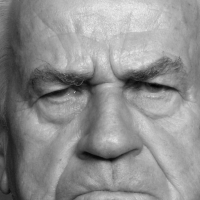

In [5]:
cv2_imshow(images[0])

Realizamos o levantamento de quais categorias existem e mapeamos as expressões para valores numéricos para se adequar ao treinamento do keras:

In [0]:
unique_labels = list(set(labels))
wi = {v: i for i, v in enumerate(unique_labels)}
rwi = {i: v for i, v in enumerate(unique_labels)}
num_labels = [wi[l] for l in labels]

In [7]:
print(unique_labels)

['s', 'f', 'a', 'd', 'h', 'n']


* n - *Neutral* 
* h - *Happy*
* a - *Anger*
* s - *Sadness*
* f - *Fear*
* d - *Disgust*

In [8]:
print(rwi)
print(wi)

{0: 's', 1: 'f', 2: 'a', 3: 'd', 4: 'h', 5: 'n'}
{'s': 0, 'f': 1, 'a': 2, 'd': 3, 'h': 4, 'n': 5}


In [0]:
imagesnp = np.array(images)
imagesnp = imagesnp.reshape(-1, 200, 200,1)

In [10]:
regularization = l2(0.01)
img_input = Input((200, 200, 1))
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(len(unique_labels), (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 198, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 198, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 198, 198, 8)  0           batch_normalization_1[0][0]      
______________________________________________________________________________

In [0]:
cat_labels = keras.utils.to_categorical(num_labels)
x, y = shuffle(imagesnp, cat_labels, random_state=42)
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.15)

In [0]:
EPOCHS = 40
validation_data = (x_test, y_test)

In [13]:
modelo = model.fit(x_train, y_train, validation_data=validation_data, epochs=EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 61 samples, validate on 11 samples
Epoch 1/40
61/61 [==============================] - 6s 106ms/step - loss: 2.6304 - acc: 0.1148 - val_loss: 2.3812 - val_acc: 0.0909
Epoch 2/40
61/61 [==============================] - 1s 16ms/step - loss: 2.0063 - acc: 0.2787 - val_loss: 2.7827 - val_acc: 0.0909
Epoch 3/40
61/61 [==============================] - 1s 16ms/step - loss: 2.1839 - acc: 0.2787 - val_loss: 2.8416 - val_acc: 0.0909
Epoch 4/40
61/61 [==============================] - 1s 16ms/step - loss: 1.9899 - acc: 0.3443 - val_loss: 2.9150 - val_acc: 0.0909
Epoch 5/40
61/61 [==============================] - 1s 16ms/step - loss: 1.7649 - acc: 0.3770 - val_loss: 2.9252 - val_acc: 0.0909
Epoch 6/40
61/61 [==============================] - 1s 16ms/step - loss: 1.6406 - acc: 0.4098 - val_loss: 2.6545 - val_acc: 0.0909
Epoch 7/40
61/61 [==============================] - 1s 16ms/step - loss: 

In [14]:
print(modelo.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


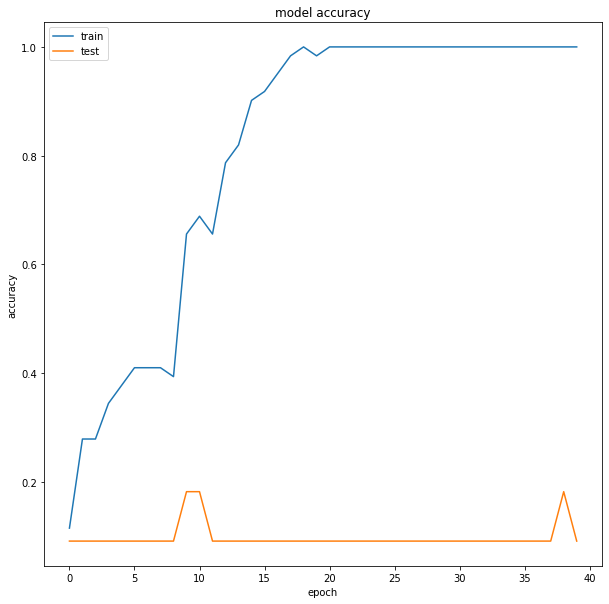

In [15]:
# summarize history for accuracy
plt.figure(figsize=(10,10))
plt.plot(modelo.history['acc'])
plt.plot(modelo.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("/content/gdrive/My Drive/PercepcaoComputacional/modelo/modelo.h5")

# Demonstração

In [17]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/PercepcaoComputacional/modelo/modelo.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 198, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 198, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 198, 198, 8)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
test_img = cv2.imread('unnamed.jpg')
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
rects=dnnFaceDetector(test_gray,1)

left,top,right,bottom=0,0,0,0

# Para todo rosto da imagem, é gerado um par com as coordenadas
# que definem o bounding box. Como temo apenas um rosto em cada
# imagem, sempre haverá apenas 1 interação nesse for
for (i,rect) in enumerate(rects):
  left=rect.rect.left() #x1
  top=rect.rect.top() #y1
  right=rect.rect.right() #x2
  bottom=rect.rect.bottom() #y2
  width=right-left
  height=bottom-top

# Realizamos a cropagem da imagem 
test_img_crop=test_gray[top:top+height,left:left+width]
# Reduzimos sua dimensão para um valor predefinido
test_img = cv2.resize(test_img_crop,(200, 200), interpolation = cv2.INTER_AREA)

imagenp = np.array(test_img)
imagenp = imagenp.reshape(-1, 200, 200,1)

result = model.predict(imagenp)

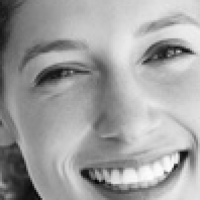

In [23]:
cv2_imshow(test_img)

In [24]:
labels = {0: 'f', 1: 'd', 2: 'a', 3: 's', 4: 'n', 5: 'h'}
labels[result.argmax()]

'd'